# Taller 3-3. Redes Neuronales Recurrentes

Este taller consiste en actualizar el taller anterior (3), es decir, usar redes neuronales recurrentes, en vez de redes neuronales multicapa (MLP, multilayer perceptron).

## Ejercicio 1. 
Use el dataset de `progressive-tweet-sentiment.csv` (el del taller anterior), para realizar una clasificación de las 4 clases en que pertenece cada tweet, usando redes neuronales recurrentes. Es decir, que esta vez, no va a usar sólo capas MLP, sino una o varias capas recurrentes, seguida de una capa lineal (full connected, o densa). Pruebe diferentes configuraciones (use recurrente básica, LSTM, GRU y bidireccionalidad). 

Debe utilizar pytorch. Grafique el loss y el accuracy, tanto para el entrenamiento como para la validación. Escoja el mejor modelo probando con un buen número de epochs (use el optimizador de Adam con learning rate por defecto de 0.001).

Recuerde que en este ejercicio no va a usar word2vec, sino una capa de embeddings.

A continuación muestro como leer el conjunto de datos, crear un `Dataset`de pytorch y dividir en un training y validation set (si se quiere un test se puede repetir el proceso)

In [2]:
import torch
import pandas as pd

from torch.utils.data import Dataset
from torch.utils.data.dataset import random_split

# tokenizacion 
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from collections import Counter, OrderedDict

#indexando tokens
from torchtext.vocab import vocab

#Definir funciones de transformacion
import torch
import torch.nn as nn

# para batch
from torch.utils.data import DataLoader


In [3]:
# Global variables
SEED_SET = torch.manual_seed(1)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
class TextData(Dataset):
    '''
    Dataset basico para leer los datos de tweets
    '''
    def __init__(self, filename):
        super(TextData, self).__init__()
        df = pd.read_csv(filename,encoding='latin-1')
        self.df = df[["target", "tweet"]]
        
    def __getitem__(self, index):
        return self.df.iloc[index,0], self.df.iloc[index,1]
    
    def __len__(self):
        return len(self.df)

In [5]:
ds = TextData("data/progressive-tweet-sentiment.csv")
train_dataset, valid_dataset = random_split(ds,
 [int(len(ds)*0.7),len(ds) - int(len(ds)*0.7)], SEED_SET)

In [6]:
#Generando test_dataset 
temp_ds = list(train_dataset)
train_dataset, test_dataset = random_split(temp_ds,
 [int(len(temp_ds)*0.7),len(temp_ds)-int(len(temp_ds)*0.7)], SEED_SET)
del temp_ds

#### Tokenización

In [7]:
nltk.download("stopwords")
misstop = stopwords.words('english')
nltk.download("punkt")

#funcion de limpieza de tweets
def tokenizacion(text):
  def limpieza(text):
    text=re.sub(r'@_[A-Za-z0-9]+_','',text) #Remover @_menciones_
    text=re.sub(r'@[A-Za-z0-9]+_[A-Za-z0-9]+','',text) #Remover @menciones_
    text=re.sub(r'@[A-Za-z0-9]+','',text) #Remover @menciones
    text=re.sub(r'https?:\/\/\S+','',text) #Remover Hypervinculos
    text=re.sub(r'RT[\s]+','',text) #Remover Retweets
    text=re.sub(r'[^\w\s]',"",text) #remover signos de puntuacion
    text=re.sub(r'#[A-Za-z0-9]+','',text) #Remover "#"
    #text=re.sub(r'[0-9]','',text) #remover numeros
    text=re.sub(r'[^\w\s]',"",text) #remover signos de puntuacion
    text=re.sub(r'\n|\t',' ',text) #remover saltos de linea
    text=re.sub(r'\@',' ',text) #remover "@"
    text=re.sub(r'[\s]+',' ',text) #reemplazar espacios dobles por espacion sencillos
    text=re.sub(r"^[\s]",' ',text) #eliminar espacios al inicio de cada tweet
    text=text.lower() #todo a minuscula
    return text
  
  text2=limpieza(text)

  #tokenizar tweet eliminando stopwords
  token1=word_tokenize(text2)
  token2=[]
  for word in token1:
    if word not in misstop: 
      token2.append(word)
  return token2

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jessuarez/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jessuarez/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
token_counts = Counter()
for label, line in train_dataset:
    tokens = tokenizacion(line)
    token_counts.update(tokens)


print('Vocab-size:', len(token_counts))

Vocab-size: 2584


#### Indexando Tokens

In [9]:
## Paso 3: Codificación de cada token único en enteros

sorted_by_freq_tuples = sorted(token_counts.items(), key=lambda x: x[1], reverse=True)
ordered_dict = OrderedDict(sorted_by_freq_tuples)

vocab = vocab(ordered_dict)

vocab.insert_token("<pad>", 0)
vocab.insert_token("<unk>", 1)
vocab.set_default_index(1)

print([vocab[token] for token in ['this', 'is', 'an', 'example']])

[1, 1, 1, 1249]


**Paso 4: Etiquetado y Codificacion**

In [10]:
text_pipeline = lambda x: [vocab[token] for token in tokenizacion(x)]
label_pipeline = lambda x: 0. if x == 'Atheism' else 1. if x=='Feminist Movement' else 2. if x=='Hillary Clinton' else 3. if x=='Legalization of Abortion' else -1.

#Definir funcion de trnasformacion y codificacion
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), 
                                      dtype=torch.int64)
        text_list.append(processed_text)
        lengths.append(processed_text.size(0))
    label_list = torch.tensor(label_list)
    lengths = torch.tensor(lengths)
    padded_text_list = nn.utils.rnn.pad_sequence(
        text_list, batch_first=True)
    return padded_text_list.to(device), label_list.to(device), lengths.to(device)

In [11]:
## Toma un pequeño batch
dataloader = DataLoader(train_dataset, batch_size=5, shuffle=False, collate_fn=collate_batch)

text_batch, label_batch, length_batch = next(iter(dataloader))
print(text_batch)
print(label_batch)
print(length_batch)
print(text_batch.shape)

tensor([[ 88, 790, 197,   3,  22,  13,  11, 107, 435, 436, 437],
        [ 55, 791, 792, 438, 289, 793,  24, 157,   0,   0,   0],
        [794,  17,  22,  17, 158,  23, 439,   0,   0,   0,   0],
        [440, 198, 441,  34, 442, 443,   0,   0,   0,   0,   0],
        [  5, 290, 795, 290, 796, 290, 159, 444, 797, 108,   0]])
tensor([2., 2., 2., 2., 2.])
tensor([11,  8,  7,  6, 10])
torch.Size([5, 11])


**Batching de los datasets**

In [12]:
batch_size = 256

train_dl = DataLoader(train_dataset, batch_size=batch_size,
                      shuffle=True, collate_fn=collate_batch)
valid_dl = DataLoader(valid_dataset, batch_size=batch_size,
                      shuffle=False, collate_fn=collate_batch)
test_dl = DataLoader(test_dataset, batch_size=batch_size,
                     shuffle=False, collate_fn=collate_batch)


**Modelacion**

Parametros 

In [13]:
vocab_size = len(vocab)
embed_dim = 64
rnn_hidden_size = 64
fc_hidden_size = 64
num_epochs = 500
lr=0.001
num_classes=4
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #carga de la red neuronal en la CPU o en la GPU
torch.manual_seed(1)

Modelo 1: Red Neuronal Recurrente Simple

In [14]:
class RNN_Simple(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.RNN(embed_dim, rnn_hidden_size,
                           batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        out, (hidden) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

model1 = RNN_Simple(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model1 = model1.to(device)

In [15]:
import numpy as np
def train(dataloader):
    model1.train()
    total_acc, total_loss = 0, 0
    losses,acc_acum,nums=0,0,0

    for text_batch, label_batch, lengths in dataloader:
        optimizer.zero_grad()
        y_test=label_batch.long()
        y_pred = torch.argmax(model1(text_batch, lengths), 1)

        pred = model1(text_batch, lengths)
        loss = loss_func(pred, y_test)
        loss.backward()
        optimizer.step()
  
        total_acc += (y_pred == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)

    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

def evaluate(dataloader):
    model1.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            #revisar funcion de perdida
            y_pred = torch.argmax(model1(text_batch, lengths), 1)
            y_test=label_batch.long()
            pred = model1(text_batch, lengths)
            loss = loss_func(pred, y_test)
            total_acc += (y_pred == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

epoch: 0,    train_loss: 1.3832     valid_loss: 1.3844, valid_acc: 0.2270
epoch: 10,    train_loss: 1.3770     valid_loss: 1.3831, valid_acc: 0.2299
epoch: 20,    train_loss: 1.3721     valid_loss: 1.3818, valid_acc: 0.2270
epoch: 30,    train_loss: 1.3673     valid_loss: 1.3806, valid_acc: 0.2356
epoch: 40,    train_loss: 1.3625     valid_loss: 1.3794, valid_acc: 0.2414
epoch: 50,    train_loss: 1.3573     valid_loss: 1.3782, valid_acc: 0.2500
epoch: 60,    train_loss: 1.3519     valid_loss: 1.3771, valid_acc: 0.2500
epoch: 70,    train_loss: 1.3460     valid_loss: 1.3761, valid_acc: 0.2471
epoch: 80,    train_loss: 1.3394     valid_loss: 1.3752, valid_acc: 0.2500
epoch: 90,    train_loss: 1.3319     valid_loss: 1.3743, valid_acc: 0.2529
epoch: 100,    train_loss: 1.3234     valid_loss: 1.3736, valid_acc: 0.2586
epoch: 110,    train_loss: 1.3139     valid_loss: 1.3731, valid_acc: 0.2644
epoch: 120,    train_loss: 1.3029     valid_loss: 1.3728, valid_acc: 0.2759
epoch: 130,    train_lo

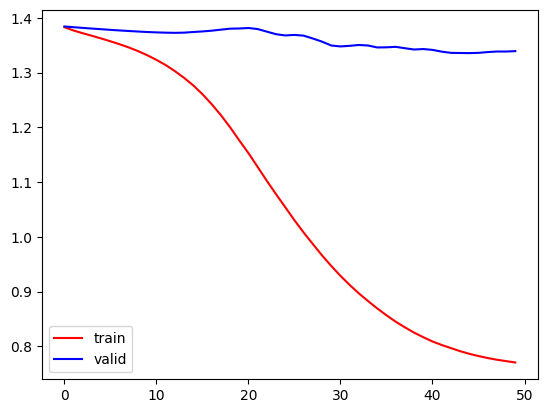

In [17]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
#loss_fn = nn.CrossEntropyLoss()

loss_func = F.cross_entropy
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

  if epoch % 10 == 0:
    acc_train, loss_train = train(train_dl)
    acc_valid, loss_valid = evaluate(valid_dl)
    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    print(f"epoch: {epoch},    train_loss: {loss_train:.4f} \
    valid_loss: {loss_valid:.4f}, valid_acc: {acc_valid:.4f}")

plt.plot(range(len(train_losses)), train_losses, 'r', label='train')
plt.plot(range(len(train_losses)), valid_losses, 'b', label = 'valid')
plt.legend()

In [18]:
acc_test, _ = evaluate(test_dl)
print(f'test_accuracy: {acc_test:.4f}') 

test_accuracy: 0.4098


Modelo 1.1 Red Neuronal Recurrente Bidireccional Simple

In [19]:
class RNN_BI(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.RNN(embed_dim, rnn_hidden_size, 
                           batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(rnn_hidden_size*2, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        _, (hidden) = self.rnn(out)
        out = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

model1_1 = RNN_BI(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model1_1 = model1_1.to(device)

In [20]:
import numpy as np
def train_BI(dataloader):
    model1_1.train()
    total_acc, total_loss = 0, 0

    for text_batch, label_batch, lengths in dataloader:
        optimizer.zero_grad()
        y_test=label_batch.long()
        y_pred = torch.argmax(model1_1(text_batch, lengths), 1)

        pred = model1_1(text_batch, lengths)
        loss = loss_func(pred, y_test)
        loss.backward()
        optimizer.step()
  
        total_acc += (y_pred == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)

    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

def evaluate_BI(dataloader):
    model1_1.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            #revisar funcion de perdida
            y_pred = torch.argmax(model1_1(text_batch, lengths), 1)
            y_test=label_batch.long()
            pred = model1_1(text_batch, lengths)
            loss = loss_func(pred, y_test)
            total_acc += (y_pred == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

epoch: 0,    train_loss: 1.3943     valid_loss: 1.3876, valid_acc: 0.2557
epoch: 10,    train_loss: 1.3842     valid_loss: 1.3854, valid_acc: 0.2759
epoch: 20,    train_loss: 1.3763     valid_loss: 1.3832, valid_acc: 0.2989
epoch: 30,    train_loss: 1.3689     valid_loss: 1.3809, valid_acc: 0.3218
epoch: 40,    train_loss: 1.3614     valid_loss: 1.3787, valid_acc: 0.3276
epoch: 50,    train_loss: 1.3535     valid_loss: 1.3765, valid_acc: 0.3161
epoch: 60,    train_loss: 1.3445     valid_loss: 1.3744, valid_acc: 0.3103
epoch: 70,    train_loss: 1.3347     valid_loss: 1.3721, valid_acc: 0.3305
epoch: 80,    train_loss: 1.3233     valid_loss: 1.3697, valid_acc: 0.3305
epoch: 90,    train_loss: 1.3100     valid_loss: 1.3674, valid_acc: 0.3420
epoch: 100,    train_loss: 1.2949     valid_loss: 1.3651, valid_acc: 0.3477
epoch: 110,    train_loss: 1.2771     valid_loss: 1.3624, valid_acc: 0.3448
epoch: 120,    train_loss: 1.2571     valid_loss: 1.3595, valid_acc: 0.3621
epoch: 130,    train_lo

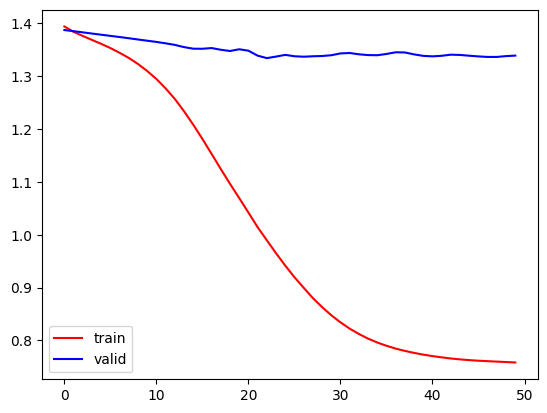

In [21]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
#loss_fn = nn.CrossEntropyLoss()

loss_func = F.cross_entropy
optimizer = torch.optim.Adam(model1_1.parameters(), lr=lr)

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

  if epoch % 10 == 0:
    acc_train, loss_train = train_BI(train_dl)
    acc_valid, loss_valid = evaluate_BI(valid_dl)
    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    print(f"epoch: {epoch},    train_loss: {loss_train:.4f} \
    valid_loss: {loss_valid:.4f}, valid_acc: {acc_valid:.4f}")

plt.plot(range(len(train_losses)), train_losses, 'r', label='train')
plt.plot(range(len(train_losses)), valid_losses, 'b', label = 'valid')
plt.legend()

In [22]:
acc_test, _ = evaluate_BI(test_dl)
print(f'test_accuracy: {acc_test:.4f}') 

test_accuracy: 0.4057


Modelo 2: Red Neuronal Recurrente Cerrada GRU

In [23]:
class RNN_GRU(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.GRU(embed_dim, rnn_hidden_size,
                           batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        out, (hidden) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

model2 = RNN_GRU(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model2 = model2.to(device)

In [24]:
import numpy as np
def train_GRU(dataloader):
    model2.train()
    total_acc, total_loss = 0, 0
    losses,acc_acum,nums=0,0,0

    for text_batch, label_batch, lengths in dataloader:
        optimizer.zero_grad()
        y_test=label_batch.long()
        y_pred = torch.argmax(model2(text_batch, lengths), 1)

        pred = model2(text_batch, lengths)
        loss = loss_func(pred, y_test)
        loss.backward()
        optimizer.step()
  
        total_acc += (y_pred == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)

    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

def evaluate_GRU(dataloader):
    model2.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            #revisar funcion de perdida
            y_pred = torch.argmax(model2(text_batch, lengths), 1)
            y_test=label_batch.long()
            pred = model2(text_batch, lengths)
            loss = loss_func(pred, y_test)
            total_acc += (y_pred == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

epoch: 0,    train_loss: 1.3854     valid_loss: 1.3858, valid_acc: 0.2586
epoch: 10,    train_loss: 1.3803     valid_loss: 1.3839, valid_acc: 0.2644
epoch: 20,    train_loss: 1.3762     valid_loss: 1.3822, valid_acc: 0.2874
epoch: 30,    train_loss: 1.3718     valid_loss: 1.3805, valid_acc: 0.2874
epoch: 40,    train_loss: 1.3674     valid_loss: 1.3786, valid_acc: 0.2816
epoch: 50,    train_loss: 1.3624     valid_loss: 1.3765, valid_acc: 0.2874
epoch: 60,    train_loss: 1.3567     valid_loss: 1.3741, valid_acc: 0.3132
epoch: 70,    train_loss: 1.3503     valid_loss: 1.3714, valid_acc: 0.3218
epoch: 80,    train_loss: 1.3430     valid_loss: 1.3682, valid_acc: 0.3276
epoch: 90,    train_loss: 1.3343     valid_loss: 1.3646, valid_acc: 0.3333
epoch: 100,    train_loss: 1.3244     valid_loss: 1.3605, valid_acc: 0.3391
epoch: 110,    train_loss: 1.3133     valid_loss: 1.3559, valid_acc: 0.3362
epoch: 120,    train_loss: 1.3000     valid_loss: 1.3506, valid_acc: 0.3477
epoch: 130,    train_lo

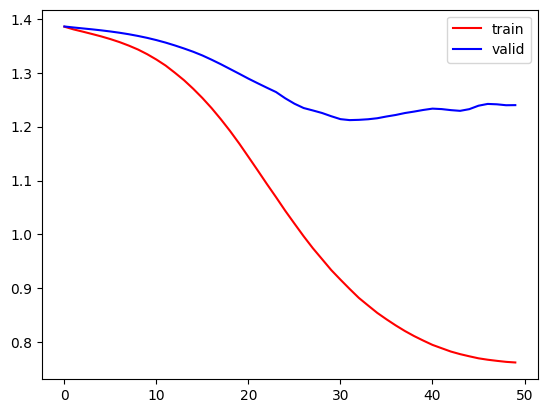

In [25]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
#loss_fn = nn.CrossEntropyLoss()

loss_func = F.cross_entropy
optimizer = torch.optim.Adam(model2.parameters(), lr=lr)

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

  if epoch % 10 == 0:
    acc_train, loss_train = train_GRU(train_dl)
    acc_valid, loss_valid = evaluate_GRU(valid_dl)
    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    print(f"epoch: {epoch},    train_loss: {loss_train:.4f} \
    valid_loss: {loss_valid:.4f}, valid_acc: {acc_valid:.4f}")

plt.plot(range(len(train_losses)), train_losses, 'r', label='train')
plt.plot(range(len(train_losses)), valid_losses, 'b', label = 'valid')
plt.legend()

In [26]:
acc_test, _ = evaluate_GRU(test_dl)
print(f'test_accuracy: {acc_test:.4f}') 

test_accuracy: 0.5164


Modelo 2.1: Red Neuronal Recurrente Cerrada (GRU) Bidireccional

In [27]:
class RNN_GRU_BI(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.GRU(embed_dim, rnn_hidden_size, 
                           batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(rnn_hidden_size*2, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        _, (hidden) = self.rnn(out)
        out = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
 
model2_1 = RNN_GRU_BI(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model2_1 = model2_1.to(device)

In [28]:
import numpy as np
def train_GRU_BI(dataloader):
    model2_1.train()
    total_acc, total_loss = 0, 0
    losses,acc_acum,nums=0,0,0

    for text_batch, label_batch, lengths in dataloader:
        optimizer.zero_grad()
        y_test=label_batch.long()
        y_pred = torch.argmax(model2_1(text_batch, lengths), 1)

        pred = model2_1(text_batch, lengths)
        loss = loss_func(pred, y_test)
        loss.backward()
        optimizer.step()
  
        total_acc += (y_pred == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)

    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

def evaluate_GRU_BI(dataloader):
    model2_1.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            #revisar funcion de perdida
            y_pred = torch.argmax(model2_1(text_batch, lengths), 1)
            y_test=label_batch.long()
            pred = model2_1(text_batch, lengths)
            loss = loss_func(pred, y_test)
            total_acc += (y_pred == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

epoch: 0,    train_loss: 1.3889     valid_loss: 1.3852, valid_acc: 0.2874
epoch: 10,    train_loss: 1.3827     valid_loss: 1.3839, valid_acc: 0.2902
epoch: 20,    train_loss: 1.3775     valid_loss: 1.3826, valid_acc: 0.2902
epoch: 30,    train_loss: 1.3725     valid_loss: 1.3812, valid_acc: 0.3046
epoch: 40,    train_loss: 1.3669     valid_loss: 1.3798, valid_acc: 0.3075
epoch: 50,    train_loss: 1.3607     valid_loss: 1.3781, valid_acc: 0.3534
epoch: 60,    train_loss: 1.3536     valid_loss: 1.3761, valid_acc: 0.3649
epoch: 70,    train_loss: 1.3451     valid_loss: 1.3738, valid_acc: 0.3534
epoch: 80,    train_loss: 1.3349     valid_loss: 1.3708, valid_acc: 0.3621
epoch: 90,    train_loss: 1.3226     valid_loss: 1.3675, valid_acc: 0.3649
epoch: 100,    train_loss: 1.3081     valid_loss: 1.3635, valid_acc: 0.3908
epoch: 110,    train_loss: 1.2902     valid_loss: 1.3588, valid_acc: 0.3937
epoch: 120,    train_loss: 1.2702     valid_loss: 1.3532, valid_acc: 0.3908
epoch: 130,    train_lo

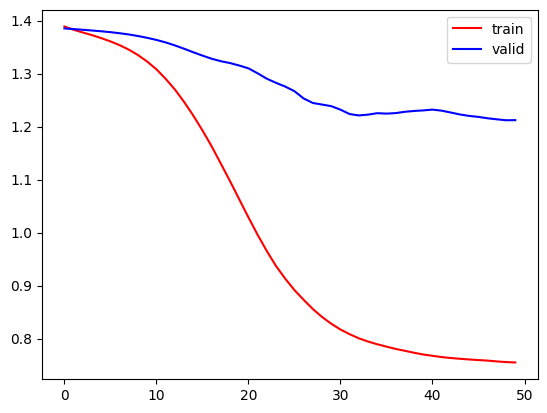

In [29]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
#loss_fn = nn.CrossEntropyLoss()

loss_func = F.cross_entropy
optimizer = torch.optim.Adam(model2_1.parameters(), lr=lr)

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

  if epoch % 10 == 0:
    acc_train, loss_train = train_GRU_BI(train_dl)
    acc_valid, loss_valid = evaluate_GRU_BI(valid_dl)
    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    print(f"epoch: {epoch},    train_loss: {loss_train:.4f} \
    valid_loss: {loss_valid:.4f}, valid_acc: {acc_valid:.4f}")

plt.plot(range(len(train_losses)), train_losses, 'r', label='train')
plt.plot(range(len(train_losses)), valid_losses, 'b', label = 'valid')
plt.legend()

In [30]:
acc_test, _ = evaluate_GRU_BI(test_dl)
print(f'test_accuracy: {acc_test:.4f}') 

test_accuracy: 0.5328


Modelo 3:Red Neuronal Recurrente con memoria a largo plazo LSTM

In [31]:
class RNN_LSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, 
                           batch_first=True)
        self.fc1 = nn.Linear(rnn_hidden_size, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        out, (hidden, cell) = self.rnn(out)
        out = hidden[-1, :, :]
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out



model3 = RNN_LSTM(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model3 = model3.to(device)

In [32]:
import numpy as np
def train_LSTM(dataloader):
    model3.train()
    total_acc, total_loss = 0, 0
    losses,acc_acum,nums=0,0,0

    for text_batch, label_batch, lengths in dataloader:
        optimizer.zero_grad()
        y_test=label_batch.long()
        y_pred = torch.argmax(model3(text_batch, lengths), 1)

        pred = model3(text_batch, lengths)
        loss = loss_func(pred, y_test)
        loss.backward()
        optimizer.step()
  
        total_acc += (y_pred == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)

    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

def evaluate_LSTM(dataloader):
    model3.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            #revisar funcion de perdida
            y_pred = torch.argmax(model3(text_batch, lengths), 1)
            y_test=label_batch.long()
            pred = model3(text_batch, lengths)
            loss = loss_func(pred, y_test)
            total_acc += (y_pred == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

epoch: 0,    train_loss: 1.3864     valid_loss: 1.3872, valid_acc: 0.2759
epoch: 10,    train_loss: 1.3842     valid_loss: 1.3867, valid_acc: 0.2759
epoch: 20,    train_loss: 1.3823     valid_loss: 1.3862, valid_acc: 0.2816
epoch: 30,    train_loss: 1.3803     valid_loss: 1.3858, valid_acc: 0.2787
epoch: 40,    train_loss: 1.3783     valid_loss: 1.3852, valid_acc: 0.2759
epoch: 50,    train_loss: 1.3761     valid_loss: 1.3846, valid_acc: 0.2759
epoch: 60,    train_loss: 1.3735     valid_loss: 1.3839, valid_acc: 0.2816
epoch: 70,    train_loss: 1.3704     valid_loss: 1.3830, valid_acc: 0.2816
epoch: 80,    train_loss: 1.3668     valid_loss: 1.3820, valid_acc: 0.2845
epoch: 90,    train_loss: 1.3624     valid_loss: 1.3808, valid_acc: 0.2874
epoch: 100,    train_loss: 1.3571     valid_loss: 1.3793, valid_acc: 0.2845
epoch: 110,    train_loss: 1.3506     valid_loss: 1.3773, valid_acc: 0.2845
epoch: 120,    train_loss: 1.3421     valid_loss: 1.3747, valid_acc: 0.2960
epoch: 130,    train_lo

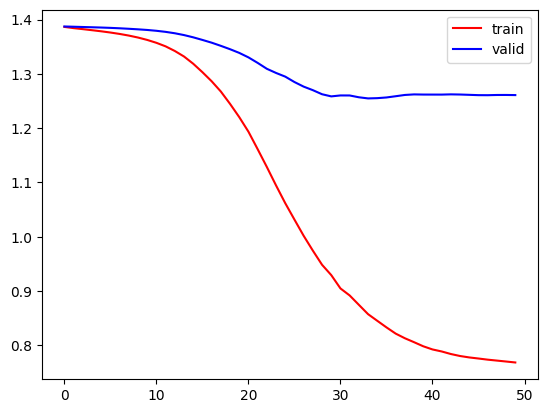

In [33]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
#loss_fn = nn.CrossEntropyLoss()

loss_func = F.cross_entropy
optimizer = torch.optim.Adam(model3.parameters(), lr=lr)

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

  if epoch % 10 == 0:
    acc_train, loss_train = train_LSTM(train_dl)
    acc_valid, loss_valid = evaluate_LSTM(valid_dl)
    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    print(f"epoch: {epoch},    train_loss: {loss_train:.4f} \
    valid_loss: {loss_valid:.4f}, valid_acc: {acc_valid:.4f}")

plt.plot(range(len(train_losses)), train_losses, 'r', label='train')
plt.plot(range(len(train_losses)), valid_losses, 'b', label = 'valid')
plt.legend()

In [34]:
acc_test, _ = evaluate_LSTM(test_dl)
print(f'test_accuracy: {acc_test:.4f}') 

test_accuracy: 0.4590


Modelo 3.1: Red Neuronal Recurrente LSTM Bidireccional

In [35]:
class RNN_LSTM_BI(nn.Module):
    def __init__(self, vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, 
                                      padding_idx=0) 
        self.rnn = nn.LSTM(embed_dim, rnn_hidden_size, 
                           batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(rnn_hidden_size*2, fc_hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(fc_hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, lengths):
        out = self.embedding(text)
        out = nn.utils.rnn.pack_padded_sequence(out, lengths.cpu().numpy(), enforce_sorted=False, batch_first=True)
        _, (hidden, cell) = self.rnn(out)
        out = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out
    

model3_1 = RNN_LSTM_BI(vocab_size, embed_dim, rnn_hidden_size, fc_hidden_size) 
model3_1 = model3_1.to(device)

In [36]:
import numpy as np
def train_LSTM_BI(dataloader):
    model3_1.train()
    total_acc, total_loss = 0, 0
    losses,acc_acum,nums=0,0,0

    for text_batch, label_batch, lengths in dataloader:
        optimizer.zero_grad()
        y_test=label_batch.long()
        y_pred = torch.argmax(model3_1(text_batch, lengths), 1)

        pred = model3_1(text_batch, lengths)
        loss = loss_func(pred, y_test)
        loss.backward()
        optimizer.step()
  
        total_acc += (y_pred == label_batch).float().sum().item()
        total_loss += loss.item()*label_batch.size(0)

    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

def evaluate_LSTM_BI(dataloader):
    model3_1.eval()
    total_acc, total_loss = 0, 0
    with torch.no_grad():
        for text_batch, label_batch, lengths in dataloader:
            #revisar funcion de perdida
            y_pred = torch.argmax(model3_1(text_batch, lengths), 1)
            y_test=label_batch.long()
            pred = model3_1(text_batch, lengths)
            loss = loss_func(pred, y_test)
            total_acc += (y_pred == label_batch).float().sum().item()
            total_loss += loss.item()*label_batch.size(0)
    return total_acc/len(dataloader.dataset), total_loss/len(dataloader.dataset)

epoch: 0,    train_loss: 1.3882     valid_loss: 1.3865, valid_acc: 0.2730
epoch: 10,    train_loss: 1.3851     valid_loss: 1.3858, valid_acc: 0.2701
epoch: 20,    train_loss: 1.3823     valid_loss: 1.3851, valid_acc: 0.2759
epoch: 30,    train_loss: 1.3797     valid_loss: 1.3843, valid_acc: 0.2615
epoch: 40,    train_loss: 1.3767     valid_loss: 1.3835, valid_acc: 0.2759
epoch: 50,    train_loss: 1.3734     valid_loss: 1.3825, valid_acc: 0.2759
epoch: 60,    train_loss: 1.3694     valid_loss: 1.3812, valid_acc: 0.2759
epoch: 70,    train_loss: 1.3643     valid_loss: 1.3796, valid_acc: 0.2787
epoch: 80,    train_loss: 1.3583     valid_loss: 1.3775, valid_acc: 0.2787
epoch: 90,    train_loss: 1.3507     valid_loss: 1.3748, valid_acc: 0.2845
epoch: 100,    train_loss: 1.3408     valid_loss: 1.3715, valid_acc: 0.2874
epoch: 110,    train_loss: 1.3288     valid_loss: 1.3675, valid_acc: 0.3017
epoch: 120,    train_loss: 1.3132     valid_loss: 1.3628, valid_acc: 0.3075
epoch: 130,    train_lo

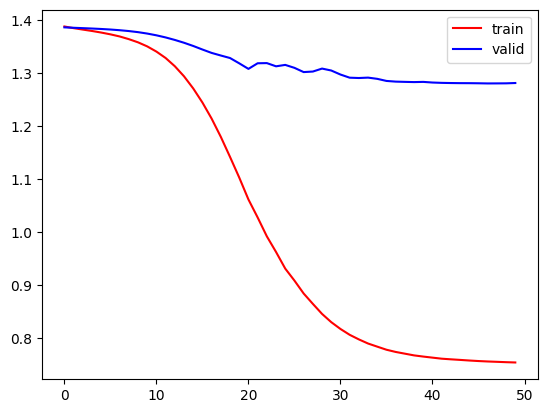

In [37]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
#loss_fn = nn.CrossEntropyLoss()

loss_func = F.cross_entropy
optimizer = torch.optim.Adam(model3_1.parameters(), lr=lr)

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

  if epoch % 10 == 0:
    acc_train, loss_train = train_LSTM_BI(train_dl)
    acc_valid, loss_valid = evaluate_LSTM_BI(valid_dl)
    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    print(f"epoch: {epoch},    train_loss: {loss_train:.4f} \
    valid_loss: {loss_valid:.4f}, valid_acc: {acc_valid:.4f}")

plt.plot(range(len(train_losses)), train_losses, 'r', label='train')
plt.plot(range(len(train_losses)), valid_losses, 'b', label = 'valid')
plt.legend()

In [38]:
acc_test, _ = evaluate_LSTM_BI(test_dl)
print(f'test_accuracy: {acc_test:.4f}') 

test_accuracy: 0.4467


In [39]:
print ('FINALIZA Y CORRE EXITOSO')

FINALIZA Y CORRE EXITOSO


## Ejercicio 2.
Ahora proceda a actualizar el ejercicio 5 del taller 3, pero usando RNNs. Es decir, debe solucionar un problema de Name Entity Recognition (NER), con un dataset pequeño creado por ustedes (con varias entidades), pero usando redes recurrentes (RNN básica, LSTM, GRU). Use GRU o LSTM.

Este ejercicio es en realidad más simple que el del anterior taller, ya que no hay necesidad de organizar las sentencias centradas en cada palabra, sino que se toma directamente cada frase (o secuencia). 

Lo importante ahora, es utilizar todos los estados de salida de la red recurrente y llevarlos a una capa lineal de clasificación. 

[Este tutorial](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html) le puede ser muy útil para desarrollar este punto. 

### Nota: puede usar las herramientas de pytorch para crear el vocabulario, y las herramientas de relleno (pad)

**Paso 1: Preparacion de los datos**

In [40]:
# Nuestros datos sin procesar, que consisten en oraciones
corpus = [
          "La gratitud es la memoria del corazón",
          "Tu sueño nunca se desvanecerá si no le dejas marchar",
          "Reciclar es muy importante en el mundo",
          "Tu vivencia más difícil es tu mejor maestra",
          "La esperanza es lo último que se pierde",
          "Tu libertad termina donde empieza la de los demás",
          "Sin sacrificio no hay victoria"
         ]

In [41]:
import re
from unicodedata import normalize
def quitartildes(s):
    # -> NFD y eliminar diacríticos
    s = re.sub(
            r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
            normalize( "NFD", s), 0, re.I
        )

    # -> NFCNosotros
    return normalize( 'NFC', s)


# La función de preprocesamiento que usaremos para generar nuestros ejemplos de entrenamiento
# Nuestra función es simple, ponemos las letras en minúsculas, quitamos tildes
# y luego tokenizamos las palabras.
def preprocess_sentence(sentence):
  return quitartildes(sentence).lower().split()


In [42]:
#importar libreria de spacy y el corpus de español
import spacy

In [43]:

spacy.cli.download("es")
nlp=spacy.load("es_core_news_sm")

⚠ As of spaCy v3.0, shortcuts like 'es' are deprecated. Please use the
full pipeline package name 'es_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 13.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


You should consider upgrading via the '/Users/jessuarez/.pyenv/versions/nlp-env/bin/python3.8 -m pip install --upgrade pip' command.


In [44]:
#tokenizar el corpus
base=" ".join(corpus).lower()
base=base=quitartildes(base)
doc1=nlp(base)

partes=[]
for x in range(1,len(doc1)):
    partes.append([doc1[x].text, doc1[x].lemma_,doc1[x].pos_, doc1[x].tag_, doc1[x].ent_type_,doc1[x].is_stop])
partes

[['gratitud', 'gratitud', 'NOUN', 'NOUN', '', False],
 ['es', 'ser', 'AUX', 'AUX', '', True],
 ['la', 'el', 'DET', 'DET', '', True],
 ['memoria', 'memoria', 'NOUN', 'NOUN', '', False],
 ['del', 'del', 'ADP', 'ADP', '', True],
 ['corazon', 'corazon', 'NOUN', 'NOUN', '', False],
 ['tu', 'tu', 'DET', 'DET', '', True],
 ['sueño', 'sueño', 'NOUN', 'NOUN', '', False],
 ['nunca', 'nunca', 'ADV', 'ADV', '', True],
 ['se', 'él', 'PRON', 'PRON', '', True],
 ['desvanecera', 'desvanecerar', 'VERB', 'VERB', '', False],
 ['si', 'si', 'SCONJ', 'SCONJ', '', True],
 ['no', 'no', 'ADV', 'ADV', '', True],
 ['le', 'él', 'PRON', 'PRON', '', True],
 ['dejas', 'dejar', 'VERB', 'VERB', '', False],
 ['marchar', 'marchar', 'VERB', 'VERB', '', False],
 ['reciclar', 'reciclar', 'VERB', 'VERB', '', False],
 ['es', 'ser', 'AUX', 'AUX', '', True],
 ['muy', 'mucho', 'ADV', 'ADV', '', True],
 ['importante', 'importante', 'ADJ', 'ADJ', '', False],
 ['en', 'en', 'ADP', 'ADP', '', True],
 ['el', 'el', 'DET', 'DET', '', T

In [45]:
# Crea nuestro conjunto de entrenamiento
train_sentences = [preprocess_sentence(sent) for sent in corpus]
train_sentences

[['la', 'gratitud', 'es', 'la', 'memoria', 'del', 'corazon'],
 ['tu',
  'sueño',
  'nunca',
  'se',
  'desvanecera',
  'si',
  'no',
  'le',
  'dejas',
  'marchar'],
 ['reciclar', 'es', 'muy', 'importante', 'en', 'el', 'mundo'],
 ['tu', 'vivencia', 'mas', 'dificil', 'es', 'tu', 'mejor', 'maestra'],
 ['la', 'esperanza', 'es', 'lo', 'ultimo', 'que', 'se', 'pierde'],
 ['tu', 'libertad', 'termina', 'donde', 'empieza', 'la', 'de', 'los', 'demas'],
 ['sin', 'sacrificio', 'no', 'hay', 'victoria']]

In [46]:
def buscar_POS(word):
  pos="OTHER"
  for i in range(len(partes)):
      if partes[i][0]==word:
        pos=partes[i][2]
        break
  return pos

In [47]:
# Nuestras etiquetas de entrenamiento
train_labels = [[buscar_POS(word) for word in sent] for sent in train_sentences]
train_labels

[['DET', 'NOUN', 'AUX', 'DET', 'NOUN', 'ADP', 'NOUN'],
 ['DET',
  'NOUN',
  'ADV',
  'PRON',
  'VERB',
  'SCONJ',
  'ADV',
  'PRON',
  'VERB',
  'VERB'],
 ['VERB', 'AUX', 'ADV', 'ADJ', 'ADP', 'DET', 'NOUN'],
 ['DET', 'NOUN', 'ADV', 'ADJ', 'AUX', 'DET', 'ADJ', 'VERB'],
 ['DET', 'NOUN', 'AUX', 'PRON', 'ADJ', 'PRON', 'PRON', 'VERB'],
 ['DET', 'NOUN', 'ADJ', 'PRON', 'VERB', 'DET', 'ADP', 'DET', 'NOUN'],
 ['ADP', 'NOUN', 'ADV', 'AUX', 'NOUN']]

In [48]:
# Encuentra todas las palabras únicas en nuestro corpus
vocabulary = set(w for s in train_sentences for w in s)

# Agrega el token desconocido a nuestro vocabulario
vocabulary.add("<unk>")

# Agregua el token <pad> a nuestro vocabulario
vocabulary.add("<pad>")

In [49]:
# Creando un diccionario para encontrar el índice de una palabra dada
ix_to_word = sorted(list(vocabulary))
word_to_ix = {word: ind for ind, word in enumerate(ix_to_word)}
word_to_ix

{'<pad>': 0,
 '<unk>': 1,
 'corazon': 2,
 'de': 3,
 'dejas': 4,
 'del': 5,
 'demas': 6,
 'desvanecera': 7,
 'dificil': 8,
 'donde': 9,
 'el': 10,
 'empieza': 11,
 'en': 12,
 'es': 13,
 'esperanza': 14,
 'gratitud': 15,
 'hay': 16,
 'importante': 17,
 'la': 18,
 'le': 19,
 'libertad': 20,
 'lo': 21,
 'los': 22,
 'maestra': 23,
 'marchar': 24,
 'mas': 25,
 'mejor': 26,
 'memoria': 27,
 'mundo': 28,
 'muy': 29,
 'no': 30,
 'nunca': 31,
 'pierde': 32,
 'que': 33,
 'reciclar': 34,
 'sacrificio': 35,
 'se': 36,
 'si': 37,
 'sin': 38,
 'sueño': 39,
 'termina': 40,
 'tu': 41,
 'ultimo': 42,
 'victoria': 43,
 'vivencia': 44}

In [50]:
#ETIQUETADO

ix_to_tag=set([item[2] for item in partes])
ix_to_tag.add("OTHER")
tag_to_ix = {tag: ind for ind, tag in enumerate(ix_to_tag)}
tag_to_ix

{'NOUN': 0,
 'ADJ': 1,
 'SCONJ': 2,
 'DET': 3,
 'VERB': 4,
 'AUX': 5,
 'ADP': 6,
 'PRON': 7,
 'ADV': 8,
 'OTHER': 9}

In [51]:
#Se requiere que todas las sentencias esten del mismo tamaño
#se crea una funcion para rellenar las sentencias y el vector de etiquetas

maxlength=max(len(sent) for sent in train_sentences)

def rellenar(v1,word):
  aux=[word for i in range(len(v1)+1,maxlength)]
  v2=v1+aux
  return v2

#rellenar el corpus de prueba
train_sentences2=[]
for sent in train_sentences:
  sent2=rellenar(sent,'<pad>')
  train_sentences2.append(sent2)

#como el etiquetado
train_labels2=[]
for sent in train_labels:
  sent2=rellenar(sent,'OTHER')
  train_labels2.append(sent2)

#unir los dos dataset
training_data=zip(train_sentences2,train_labels2)
training_data=list(training_data)


# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 32
HIDDEN_DIM = 50

**Paso 2: Modelacion**

In [52]:
import torch
import torch.nn as nn

class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, _ = self.lstm(embeds.view(len(sentence), 1, -1))
        tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

**Paso 3: Entrenamiento**

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim



torch.manual_seed(1)

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(300):  # again, normally you would NOT do 300 epochs, it is toy data
    for sentence, tags in training_data:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, tag_to_ix)

        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)

        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()


**Paso 4: Validacion**

In [54]:
training_data[0][0]

['la', 'gratitud', 'es', 'la', 'memoria', 'del', 'corazon', '<pad>', '<pad>']

In [55]:
training_data[0][1]

['DET', 'NOUN', 'AUX', 'DET', 'NOUN', 'ADP', 'NOUN', 'OTHER', 'OTHER']

In [56]:
tag_to_ix

{'NOUN': 0,
 'ADJ': 1,
 'SCONJ': 2,
 'DET': 3,
 'VERB': 4,
 'AUX': 5,
 'ADP': 6,
 'PRON': 7,
 'ADV': 8,
 'OTHER': 9}

In [57]:
tags=[]
with torch.no_grad():
    #traer el tensor final
    inputs = prepare_sequence(training_data[0][0], word_to_ix)
    tag_scores = model(inputs)
    #elegir de cada fila el valor maximo ya que esa es la etiqueta final
    print(tag_scores.max(axis=1))
    v = torch.argmax(tag_scores, axis=1)
    for i in v:
      tags.append((list(tag_to_ix.keys())[list(tag_to_ix.values()).index(i.item())])) 

tags


torch.return_types.max(
values=tensor([-0.0014, -0.0007, -0.0008, -0.0010, -0.0006, -0.0013, -0.0012, -0.0009,
        -0.0003]),
indices=tensor([3, 0, 5, 3, 0, 6, 0, 9, 9]))


['DET', 'NOUN', 'AUX', 'DET', 'NOUN', 'ADP', 'NOUN', 'OTHER', 'OTHER']

# FIN